In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 634kB 12.9MB/s 


In [2]:
%load_ext autoreload

In [3]:
import torch
from torch import tensor as t
import torch.nn.functional as F
from torch.distributions import constraints

import numpy as np

import matplotlib.pyplot as plt

import pyro
from pyro.nn import PyroSample, PyroModule
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, infer_discrete
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro import poutine

from tqdm import tqdm
import seaborn as sns

In [5]:
from generate_data import generate_regression_data, generate_background_noise, generate_function_data

In [6]:
from utils import mix_weights, mix_weights_numpy

In [ ]:
T=3
alpha=0.5
N = 200
PRIOR_RANGE = 20

In [ ]:
def model(data):
    with pyro.plate("beta_plate", T - 1):
        beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("w_plate", T):
        w = pyro.sample('w', dist.Uniform(-PRIOR_RANGE, PRIOR_RANGE))

    with pyro.plate('b_plate', T):
        b = pyro.sample('b', dist.Uniform(-PRIOR_RANGE, PRIOR_RANGE))

    with pyro.plate('sigma_plate', T):
        sigma = pyro.sample('sigma', dist.Uniform(0, 5))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        y = w[z] * data[:, 0] + b[z]

        pyro.sample("obs", dist.Normal(y, sigma[z]), obs=data[:, 1])

In [ ]:
# for computing the cluster probability given the point
# from sympy import *

# w, b, sigma, x, y = symbols('w b sigma x y')
# pdf = 1 / sigma / np.sqrt(2 * np.pi) * exp(-1/2 * (y - w * x - b) ** 2 /sigma)
# pdf = pdf.subs(sigma, 1)

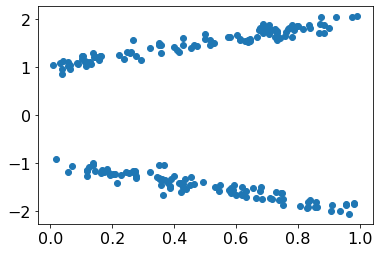

In [ ]:
w1, b1 = 1, 1
w2, b2 = -1, -1
size = N / 2
x1, y1 = generate_regression_data(w1, b1, size=size)

x2, y2 = generate_regression_data(w2, b2, size=size)

all_x = np.concatenate((x1, x2), axis=0)
all_y = np.concatenate((y1, y2), axis=0)

data = np.vstack((all_x, all_y)).T
plt.scatter(data[:, 0], data[:, 1])

In [ ]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1500, warmup_steps=200, num_chains=1)

mcmc.run(torch.from_numpy(data))

Sample: 100%|██████████| 1700/1700 [11:19,  2.50it/s, step size=6.78e-02, acc. prob=0.853]


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
clusters_probs = mix_weights_numpy(np.mean(hmc_samples['beta'].T, axis=1))
clusters_probs

array([0.49943226, 0.00615209, 0.49441564])

In [ ]:
biases = [6, 0, 4, 2, 8]

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

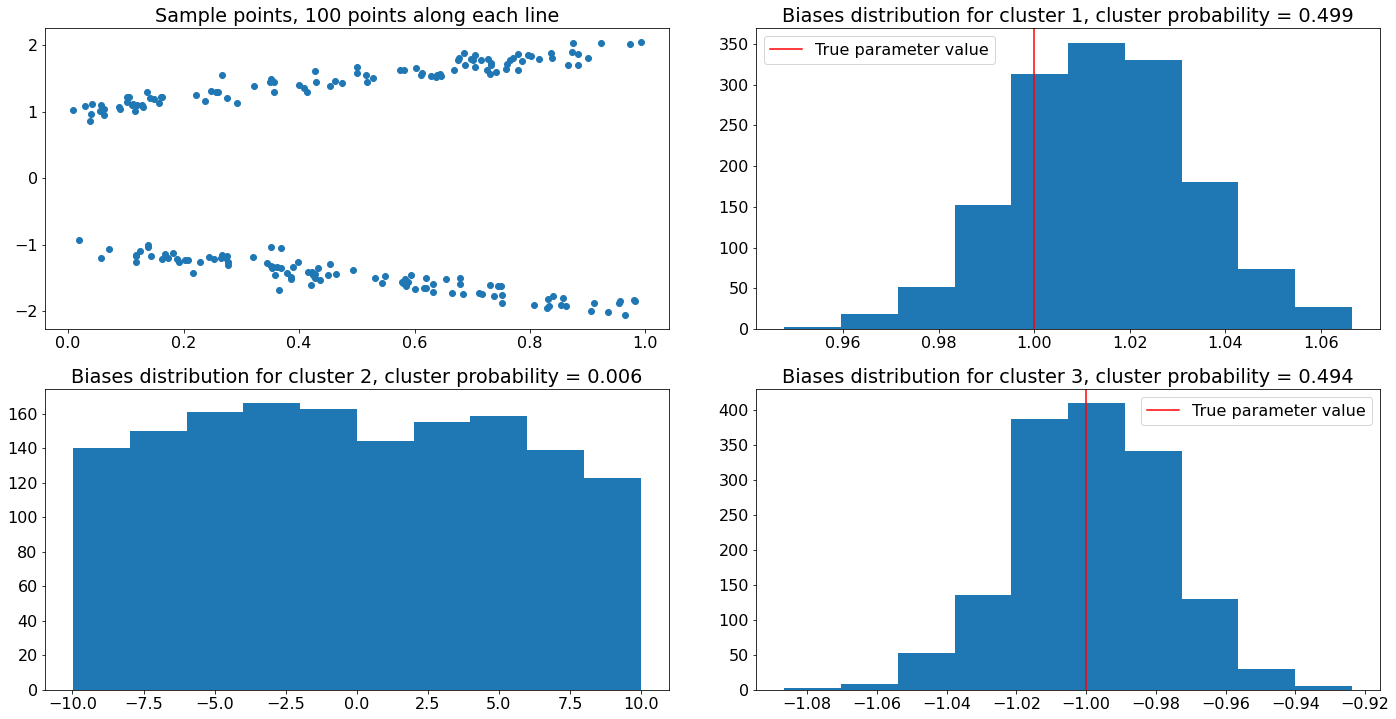

In [ ]:
fig = plt.figure(figsize=(20, 25))

ax = fig.add_subplot(5, 2, 1)
ax.scatter(data[:, 0], data[:, 1], label='regression')
ax.set_title('Sample points, 100 points along each line')

for i, (s, p) in enumerate(zip(hmc_samples['b'].T, clusters_probs)):
    ax = fig.add_subplot(5, 2, i + 2)
    ax.hist(s)
    ax.set_title(f'Biases distribution for cluster {i + 1}, cluster probability = {np.round(p, 3)}')
    if i == 0:
        ax.axvline(1, label='True parameter value', c='r')
        ax.legend()

    if i == 2:
        ax.axvline(-1, label='True parameter value', c='r')
        ax.legend()
    
plt.tight_layout()
#plt.savefig(f'results/two_lines_biases_100.png')